<a href="https://colab.research.google.com/github/cesarofs/challenge-accepted-python/blob/master/RMSE_from_NetCDF_data_English.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Installing (if necessary) and importing the libraries**

Below you can find the installation of the libraries via PIP and the explanation for its use. It is necessary to install the libraries at each new runtime when compiling this notebook using Google Colab. It is unnecessary to reinstall it with PIP if compiled on your local machine using locally installed libraries.

**1.1. Installing libraries**

Installation of **XArray** for data organizing from the NetCDF file. The argument [complete] invokes all dependencies of the library

In [ ]:
! pip install xarray[complete]

Installation of **GeoPandas** for a "Pandas-style" geospatial data organization

In [ ]:
!pip install geopandas

Installation of **PyGeoHash** to perform a data search by geographic coordinates

In [ ]:
!pip install pygeohash

Installation of **Scikit-learn**, which implements the RMSE metric


In [ ]:
!pip install Scikit-learn

Installation of **GeoPlot**, necessary for the map creation


In [ ]:
!pip install geoplot

**1.2 Importing the libraries** 

Some libraries did not require installation via pip in the Google Colab environment, so I just imported it here

In [ ]:
import xarray as xr
import pandas as pd
import geopandas as geopd
import geoplot as gplt
import urllib.request
import pygeohash as pgh
import io
from sklearn.metrics import mean_squared_error
from shapely.geometry import Point
import matplotlib.pyplot as plt

# **2. Data organization from NetCDF files**


The NetCDF files are retrieved from my GitHub repository link in the cloud, avoiding downloading the files locally


In [7]:
url = 'https://github.com/cesarofs/challenge-accepted-python/raw/master/observation.nc'

req = urllib.request.Request(url)

with urllib.request.urlopen(req) as resp:
  dataset = xr.open_dataset(io.BytesIO(resp.read()))
  observation = dataset.to_dataframe()

In [8]:
url = 'https://github.com/cesarofs/challenge-accepted-python/raw/master/forecast.nc'

req = urllib.request.Request(url)

with urllib.request.urlopen(req) as resp:
  dataset = xr.open_dataset(io.BytesIO(resp.read()))
  forecast = dataset.to_dataframe()

**2.2 Converting the forecasted data from Kelvin into Celsius (required to fit with observed data)**

In [9]:
forecast['t2m'] = (forecast['t2m'] - 273.15) 

 The format still being inappropriate because the columns "lat" and "long" are populated only in the first line of their occurrence

In [10]:
forecast.head()

t2m
lat        lon        time                          
-25.294006 -52.993698 2018-04-14 00:00:00  24.727014
                      2018-04-14 01:00:00  24.315637
                      2018-04-14 02:00:00  23.835077
                      2018-04-14 03:00:00  23.397943
                      2018-04-14 04:00:00  23.013513

I used the reset_index() command to populate the empty rows of the "lat" and "long" columns



In [11]:
forecast = forecast.reset_index()
observation = observation.reset_index()

In [12]:
forecast.head()

,lat,lon,time,t2m
0,-25.294006,-52.993698,2018-04-14 00:00:00,24.727014
1,-25.294006,-52.993698,2018-04-14 01:00:00,24.315637
2,-25.294006,-52.993698,2018-04-14 02:00:00,23.835077
3,-25.294006,-52.993698,2018-04-14 03:00:00,23.397943
4,-25.294006,-52.993698,2018-04-14 04:00:00,23.013513


**2.3 Removing null/missing values**

In [13]:
forecast = forecast[~observation['temperatura'].isna()]
observation = observation[~observation['temperatura'].isna()]

**2.4 Generating geohashes to search data by geographic coordinate**

In [14]:
observation['geohash'] = observation.apply(lambda row: pgh.encode(row['lat'], row['lon']), axis = 1)
forecast['geohash'] = forecast.apply(lambda row: pgh.encode(row['lat'], row['lon']), axis = 1)

In [15]:
observation_locations_geohashes = observation['geohash'].unique()

**2.5 Dataset slicing over intervals of 6-hour**

Creating the "cut_dataframe" function

In [16]:
def cut_dataframe(df, index_start, index_end, step):
    dataframes = []
    
    for i in range(index_start, index_end, step):
        end = i + (step - 1)

        if end <= index_end:
            dataframes.append(df.loc[i: end])
        else:
            dataframes.append(df.loc[i: -1])
    
    return dataframes

**2.6 Calculation of the RMSE over 6 hour intervals using the Scikit-learn library function "metrics.mean_squared_error" and the function "cut_dataframe"**

In [17]:
rmse_df = pd.DataFrame()

for geohash in observation_locations_geohashes:
    point_observation_data = observation[observation['geohash'] == geohash]
    
    index_start = point_observation_data.index[0]
    index_end = point_observation_data.index[-1]
    
    point_forecast_data = forecast.loc[index_start: index_end]
    
    observation_cuts = cut_dataframe(point_observation_data, index_start, index_end, 6)
    forecast_cuts = cut_dataframe(point_forecast_data, index_start, index_end, 6)
    
    data = {"lat": [], "lon": [], "start": [], "end": [], 'rmse': []}
    
    for i in range(0, len(observation_cuts)):
        observation_cut = observation_cuts[i]
        forecast_cut = forecast_cuts[i]
        
        data['lat'].append(observation_cut.iloc[0]['lat'])
        data['lon'].append(observation_cut.iloc[0]['lon'])
        
        data['start'].append(observation_cut.time.min())
        data['end'].append(observation_cut.time.max())
        
        data['rmse'].append(mean_squared_error(observation_cut['temperatura'], forecast_cut['t2m']))
    
    rmse_df = pd.concat([rmse_df, pd.DataFrame(data)])

# **3. RMSE maps at point -23.5489, -46.6388**

I applied geohashing over the data to improve the map plotting process. But I did not find the exact coordinate requested, possibly because of a geographic projection difference. So I created a BoundingBox with vertices at Latitudes -23.56 -23.52 and Longitudes -46.9 and -46.6, which contains the requested coordinate

In [18]:
sp = rmse_df.query('lat >= -23.56 and lat <= -23.52').query('lon >= -46.9 and lon <= -46.6')

Here is the Geo Data Frame for verification

In [19]:
sp

,lat,lon,start,end,rmse
0,-23.524929,-46.678299,2018-04-14 00:00:00,2018-04-14 05:00:00,0.034859
1,-23.524929,-46.678299,2018-04-14 06:00:00,2018-04-14 11:00:00,0.174092
2,-23.524929,-46.678299,2018-04-14 12:00:00,2018-04-14 17:00:00,0.056827
3,-23.524929,-46.678299,2018-04-14 18:00:00,2018-04-14 23:00:00,0.696236
4,-23.524929,-46.678299,2018-04-15 00:00:00,2018-04-15 05:00:00,2.650648
5,-23.524929,-46.678299,2018-04-15 06:00:00,2018-04-15 11:00:00,0.491424
6,-23.524929,-46.678299,2018-04-15 12:00:00,2018-04-15 17:00:00,0.592144
7,-23.524929,-46.678299,2018-04-15 18:00:00,2018-04-15 23:00:00,0.094803
8,-23.524929,-46.678299,2018-04-16 00:00:00,2018-04-16 05:00:00,0.146639
9,-23.524929,-46.678299,2018-04-16 06:00:00,2018-04-16 11:00:00,0.144386


I used the "Point" function imported from shapely.geometry and the GeoPandas library (geopd) to create a Geo Data Frame using the World Geodetic System (WGS) 1984 projection (EPSG code 4326)

In [20]:
geometries = sp.apply(lambda row: Point(row['lon'], row['lat']), axis = 1)
sp_geopd = geopd.GeoDataFrame(data = sp[['lat', 'lon', 'start', 'rmse']], geometry = geopd.GeoSeries(geometries))
sp_geopd.crs = 'epsg:4326'

I imported a zipped file with the shapefile of São Paulo city boundaries to use in the map. The file is located in my GitHub repository

In [21]:
sp_shp = geopd.read_file('https://github.com/cesarofs/challenge-accepted-python/raw/master/shapefile_SP.zip')
sp_shp.to_crs('epsg:4326', inplace = True)

Twelve maps have been generated for each interval of 6-hour. The point indicates the geographic coordinate and a label presents the RMSE value for the time interval

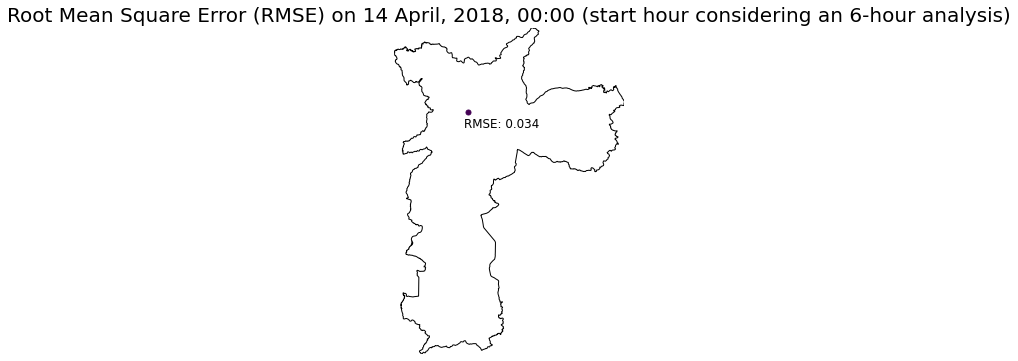

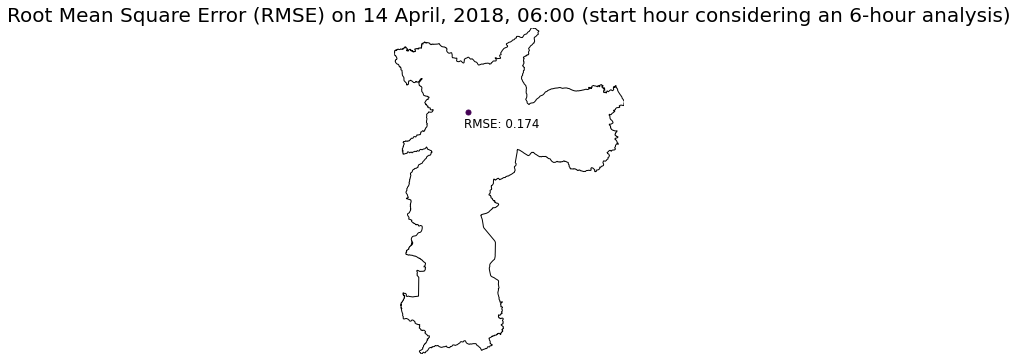

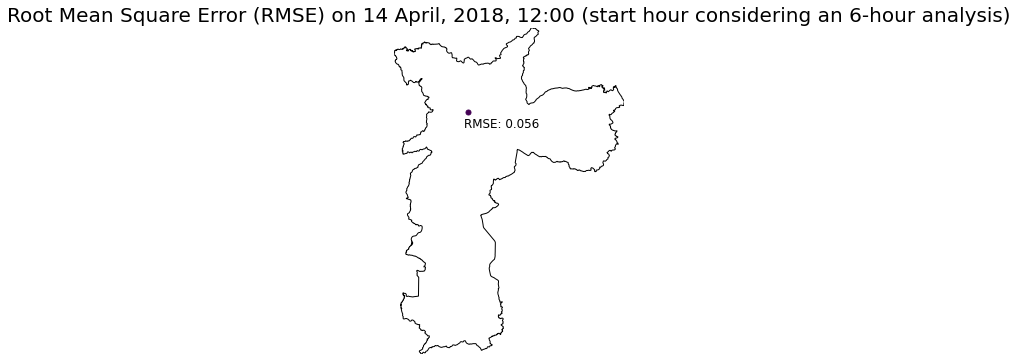

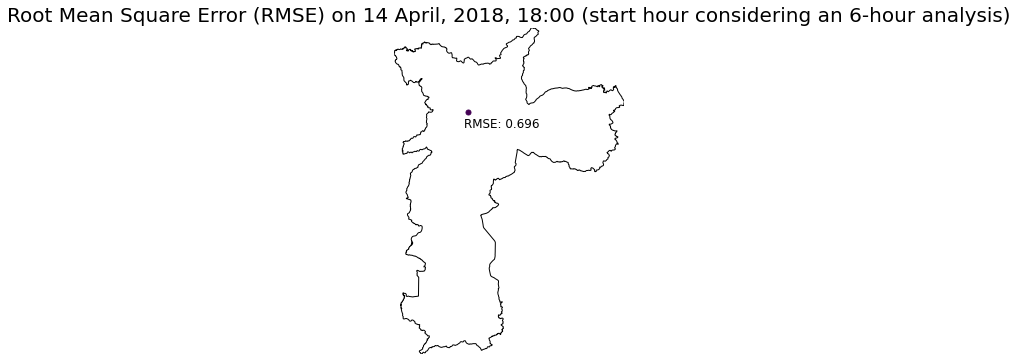

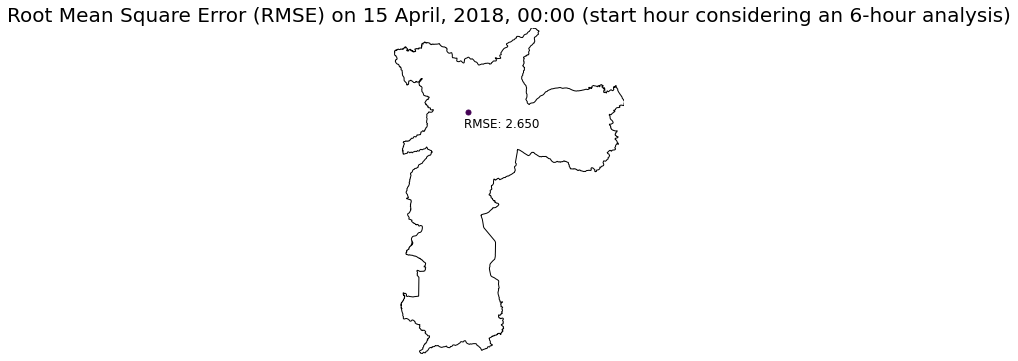

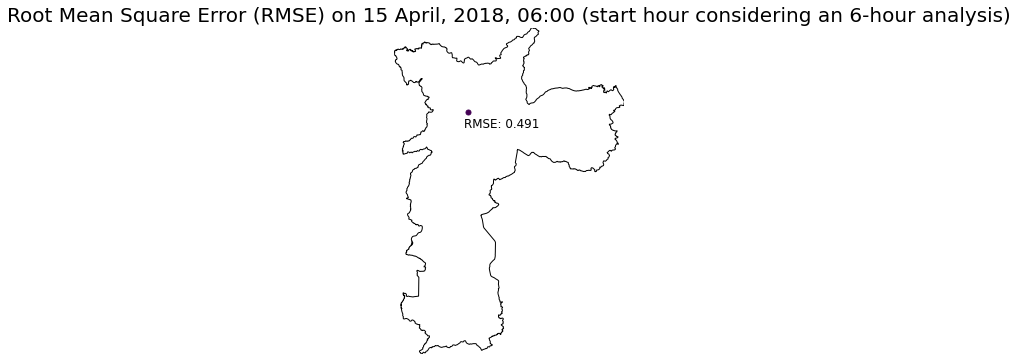

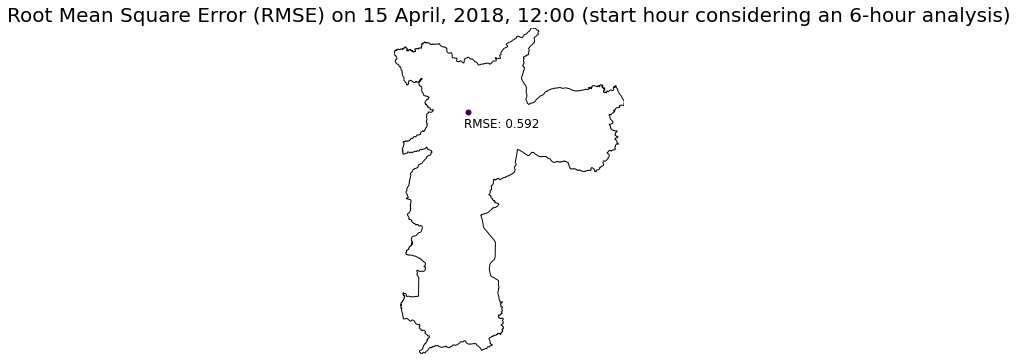

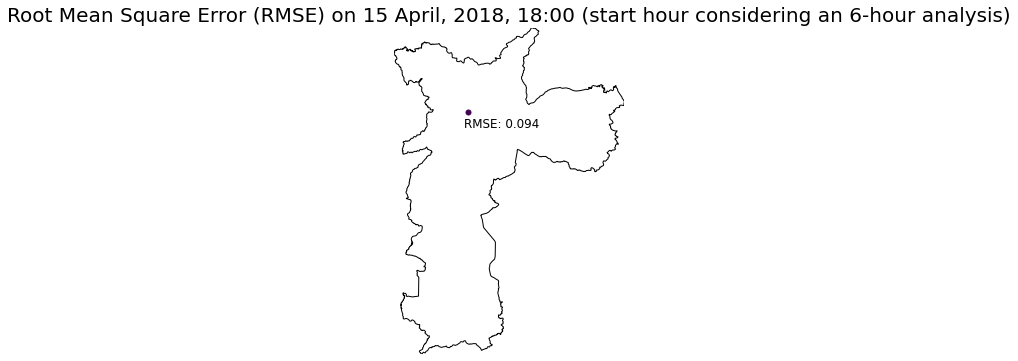

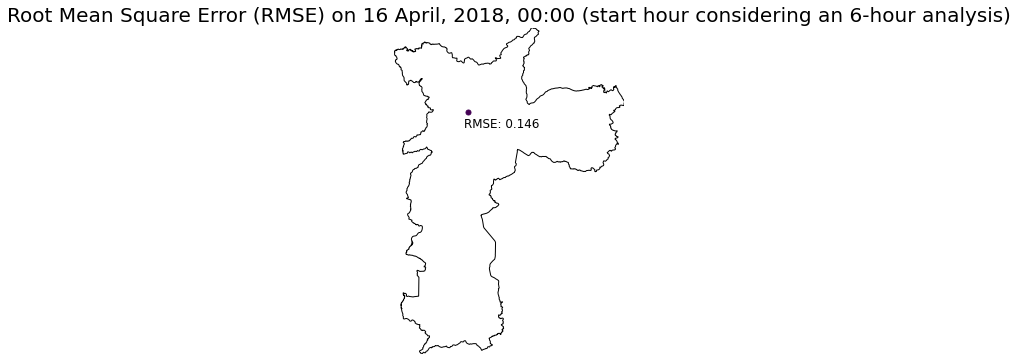

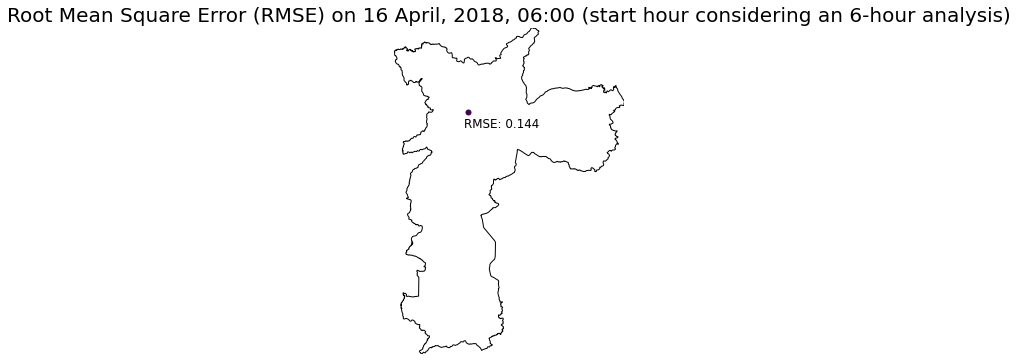

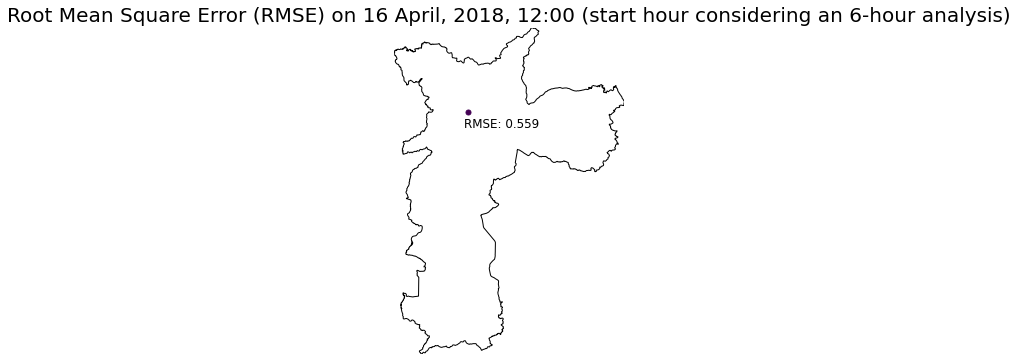

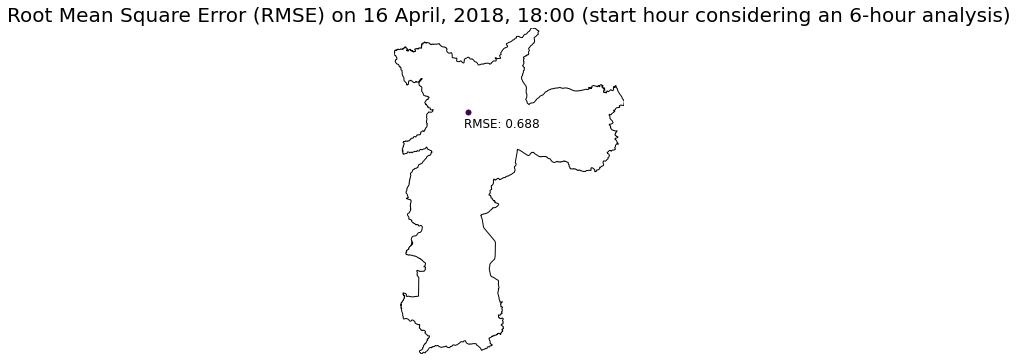

In [22]:
for row in sp_geopd.iterrows():
    geom = geopd.GeoDataFrame({'rmse': row[1]['rmse'], 'geometry': geopd.GeoSeries(row[1]['geometry'])})
    
    gplt.pointplot(
        geom, hue = 'rmse', legend=False,
        extent = sp_shp.total_bounds,
        ax = gplt.polyplot(sp_shp)
    )
    
    plt.title("Root Mean Square Error (RMSE) on " + row[1]['start'].strftime("%d %B, %Y, %H:%M (start hour considering an 6-hour analysis)"), fontsize=20)
    plt.figtext(.5, .65, "RMSE: {:.5}".format(str(row[1]['rmse'])), fontsize=12, ha='center')

# **4. RMSE Time Series Graph**

A data frame from geo data frama was created and used as a chart.



In [23]:
chart_df = sp_geopd[['start', 'rmse']]
chart_df.columns = ['datehour', 'rmse']
chart_df = chart_df.reset_index()
chart_df['datehour'] = chart_df.apply(lambda row: row['datehour'].strftime("%d/%b %H:%M"), axis = 1)

Plotting using Matplotlib

Text(0, 0.5, 'RMSE')

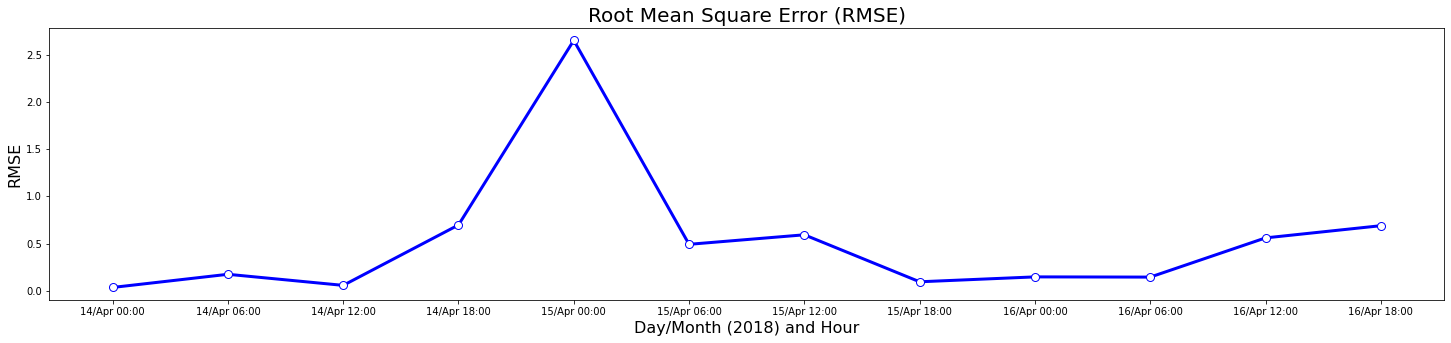

In [24]:
plt.figure(figsize=(25,5))

plt.plot('datehour', 'rmse', label = 'RMSE', data = chart_df, marker='o', markerfacecolor='white', markersize=8, color='blue', linewidth=3)

plt.title('Root Mean Square Error (RMSE)', fontsize=20)
plt.xlabel('Day/Month (2018) and Hour', fontsize=16)
plt.ylabel('RMSE', fontsize=16)

# **5. NetCDF file generation**

Re-organizing the data before exporting

In [25]:
rmse_netcdf_df = rmse_df[['lat', 'lon', 'start', 'rmse']]
rmse_netcdf_df.columns = ['lat', 'lon', 'time', 'rmse']
rmse_netcdf_df.set_index(['lat', 'lon', 'time'], inplace = True)

The RMSE chart is exported in NetCDF format. Please change the folder path to the destination location you want. If running in Google Colab it will be exported to the root folder

In [26]:
rmse_netcdf = rmse_netcdf_df.to_xarray()
rmse_netcdf.to_netcdf('rmse_netcdf.nc')